<a href="https://colab.research.google.com/github/c-h-y-a-n/WGAN-GP/blob/main/WGAN-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Preparation code in Google Colab

# Install required packages for the GAN training code
!pip install --quiet torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 \
    --index-url https://download.pytorch.org/whl/cu121

!pip install --quiet torchsummary==1.5.1

# Optional but useful for progress bars (if you add tqdm later)
!pip install --quiet tqdm

!pip install --quiet torcheval

print("Installation finished.")
import torch
import torchvision
print("torch:     ", torch.__version__)
print("torchvision:", torchvision.__version__)
print("torchsummary:", "1.5.1 (installed)")
print("torcheval:", "ready")

# link to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Unzip Dataset
!unzip -q /content/drive/MyDrive/LEGObrick.zip -d /content/lego_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 117.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 117.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
from collections import defaultdict
from PIL import Image
from IPython import display
import time
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as Transforms
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torcheval import metrics as Metrics
from tqdm.auto import tqdm

%matplotlib inline
from matplotlib import pyplot as plt





In [17]:
DATA_DIR = '/content/lego_data'
IMAGE_SIZE = 64
CHANNELS = 1 # Grayscale images
BATCH_SIZE = 128
Z_DIM = 100
NOISE_PARAM = 0.1
EPOCHS = 100
CRITIC_STEPS = 5
LAMBDA = 10
ADAM_BETA_1_C = 0.0
ADAM_BETA_1_G = 0.5
ADAM_BETA_2 = 0.9
LR = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [19]:
def save_checkpoint(epoch, generator, critic, g_optim, c_optim, history, path="/content/drive/MyDrive/dcgan_checkpoint.pth"):
    state = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'critic_state_dict': critic.state_dict(),
        'g_optimizer_state_dict': g_optim.state_dict(),
        'c_optimizer_state_dict': c_optim.state_dict(),
        'history': history,
    }
    torch.save(state, path)
    print(f"--- Checkpoint saved at epoch {epoch} to {path} ---")

def load_checkpoint(path, generator, critic, g_optim, c_optim):
    if os.path.exists(path):
        print(f"Loading checkpoint from {path}...")
        checkpoint = torch.load(path)

        generator.load_state_dict(checkpoint['generator_state_dict'])
        critic.load_state_dict(checkpoint['critic_state_dict'])
        g_optim.load_state_dict(checkpoint['g_optimizer_state_dict'])
        c_optim.load_state_dict(checkpoint['c_optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']

        print(f"Resuming from epoch {start_epoch}")
        return start_epoch, history
    else:
        print("No checkpoint found. Starting from scratch.")
        return 0, defaultdict(list)

In [5]:
class LegoData(Dataset): # from torch.utils.data
    def __init__(self, img_dir):
        super().__init__()
        self.img_dir = img_dir
        # os.listdir is not for subfolders
        #self.imgs = os.listdir(img_dir) # list of image file names
        self.imgs = []
        for root, dirs, files in os.walk(img_dir):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    self.imgs.append(os.path.join(root, file))
        self.length = len(self.imgs)

        # Define Transformer
        self.transform = Transforms.Compose([
            Transforms.Grayscale(num_output_channels=CHANNELS),
            Transforms.ToTensor(),
            Transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            Transforms.Normalize((0.5,), (0.5,))]) # Normalize to [-1, 1]

    def __len__(self):
        return self.length

    def __getitem__(self, idx): # enable indexing
        img_file = self.imgs[idx]
        image = Image.open(img_file)
        image = self.transform(image)
        return image

def get_dataloader():
    lego_dataset = LegoData(DATA_DIR)
    train_loader = DataLoader(lego_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 0, pin_memory = True)
        # pin_memory when we read data to CPU, it will be faster to transfer to GPU
        # num_workers defines the number of parallel subprocesses used to load data (optimal: 2 * number of GPU cores, but not recommedned for Windows)
    print('Train data size: ', len(lego_dataset))
    print('Num. train batchs: ', len(train_loader))
    return train_loader


In [6]:
def display_imgs(imgs):
    plt.figure(figsize = (16, 3))
    for i in range(8):
        ax = plt.subplot(1, 8, i+1)
        ax.imshow(imgs[i][0], cmap = 'gray')
        ax.axis('off')
    plt.show()

def show_records(history):
    plt.figure(figsize = (16, 3))
    for i, key in enumerate(history):
        ax = plt.subplot(1, len(history), i+1)
        ax.plot(history[key])
        ax.set_title(key)
    plt.show()

Train data size:  46384
Num. train batchs:  363


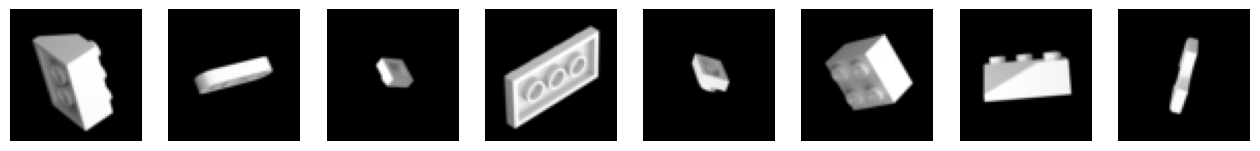

In [7]:
train_loader = get_dataloader()
real_imgs = next(iter(train_loader))
display_imgs(real_imgs)

In [9]:
# Critic Network
class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        channel_list = [CHANNELS, 64, 128, 256, 512]

        self.conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            conv_block = self.get_conv_block(channel_list[i], channel_list[i+1], bool(i))
            self.conv_layers.add_module(name = f'conv_block_{i+1}', module = conv_block)

        self.output_layer = nn.Sequential(
            nn.Conv2d(in_channels = channel_list[-1], out_channels = 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten()
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.output_layer(x)
        return x
    def get_conv_block(self, in_channels, out_channels, use_in = True):
        layers = [
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace = False),
            nn.Dropout2d(p = 0.3)
        ]
        if use_in:
            layers.insert(1, nn.InstanceNorm2d(out_channels))
        return nn.Sequential(*layers) # the * to unpack the list argument

test = Critic().to(DEVICE)
summary(test, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,024
         LeakyReLU-2           [-1, 64, 32, 32]               0
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
    InstanceNorm2d-5          [-1, 128, 16, 16]               0
         LeakyReLU-6          [-1, 128, 16, 16]               0
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8            [-1, 256, 8, 8]         524,288
    InstanceNorm2d-9            [-1, 256, 8, 8]               0
        LeakyReLU-10            [-1, 256, 8, 8]               0
        Dropout2d-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 4, 4]       2,097,152
   InstanceNorm2d-13            [-1, 512, 4, 4]               0
        LeakyReLU-14            [-1, 51

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        channel_list = [z_dim, 512, 256, 128, 64]

        self.conv_trans_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            stride = 2 if i else 1
            padding = 1 if i else 0
            trans_conv_block = self.get_conv_trans_block(channel_list[i], channel_list[i+1], stride, padding)
            self.conv_trans_layers.add_module(name = f'conv_trans_block_{i+1}',
                                              module = trans_conv_block)
        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels = channel_list[-1], out_channels = CHANNELS, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        # x = x.reshape(x.shape[0], x.shape[-1], 1, 1)
        x = self.conv_trans_layers(x)
        x = self.output_layer(x)
        return x

    def get_conv_trans_block(self, in_channels, out_channels, stride = 2, padding = 1):
        Layers = [
            nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size=4, stride=stride, padding=padding, bias=False),
            nn.InstanceNorm2d(num_features = out_channels, affine = True),
            nn.LeakyReLU(negative_slope = 0.2, inplace=False)
        ]
        return nn.Sequential(*Layers)

generator = Generator(Z_DIM).to(DEVICE)

In [11]:
class WGAN_GP(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.generator = Generator(z_dim)
        self.critic = Critic()
        self.critic_step = CRITIC_STEPS


    def generate(self, real_imgs):
        latents = torch.randn(size = (len(real_imgs), self.z_dim, 1, 1)).to(DEVICE)
        generated_imgs = self.generator(latents)
        return generated_imgs

    def gradient_penalty(self, real_imgs, fake_imgs):
        batch_size = real_imgs.size(0)
        alpha = torch.rand(batch_size, 1, 1, 1).to(DEVICE) # random weight for interpolation
        interpolated = alpha * real_imgs + (1 - alpha) * fake_imgs
        interpolated.requires_grad_(True)

        critic_interpolated = self.critic(interpolated)

        gradients = torch.autograd.grad(
            outputs=critic_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones_like(critic_interpolated).to(DEVICE),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        penalty = ((gradient_norm - 1) ** 2).mean()
        return penalty

wgan_gp = WGAN_GP(Z_DIM).to(DEVICE)

In [12]:
wgan_gp = WGAN_GP(Z_DIM).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    # It is important to use eager backend here to avoid
    # distribution mismatch in training and predicting
    dcgan = torch.compile(wgan_gp, backend='eager')
    print('model compiled')

# loss function calculated manually in training loop
# loss_fn = nn.BCEWithLogitsLoss()

c_optim = torch.optim.Adam(params=wgan_gp.critic.parameters(), lr=LR, betas=(ADAM_BETA_1_C, ADAM_BETA_2))
g_optim = torch.optim.Adam(params=wgan_gp.generator.parameters() ,lr=LR, betas=(ADAM_BETA_1_G, ADAM_BETA_2))


train_metrics = {
    'c_wass_loss': Metrics.Mean(),
    'c_gp': Metrics.Mean(),
    'c_loss': Metrics.Mean(),
    'g_loss': Metrics.Mean()
}


model compiled


In [15]:
def train(model, dataloader, c_optim, g_optim, train_metrics):
    model.train()

    for metrics in train_metrics.values():
        metrics.reset()


    total_steps = len(dataloader) // model.critic_step
    iter_dataloader = iter(dataloader)
    pbar = tqdm(range(total_steps), desc="Training WGAN-GP")

    for steps in pbar:

        #1 Update Discriminator
        for j in range(model.critic_step):
            model.critic.zero_grad()

            # the real images and fake images
            try:
                train_imgs = next(iter_dataloader).to(DEVICE)
            except StopIteration:
                iter_dataloader = iter(dataloader)
                train_imgs = next(iter_dataloader).to(DEVICE)
            generated_imgs = model.generate(train_imgs).detach() # detach to avoid backprop to generator

            # calculate EM distance and gradient penalty
            W_dist = model.critic(train_imgs).mean() - model.critic(generated_imgs).mean()
            gp = model.gradient_penalty(train_imgs, generated_imgs)
            critic_loss = -W_dist + LAMBDA * gp # lambda for gradient penalty is 10

            critic_loss.backward()
            c_optim.step()


        # 2 Update Generator
        model.generator.zero_grad()

        # generate new batch of fake images from latents
        generated_imgs_fresh = model.generate(train_imgs)

        # calculate generator loss
        g_loss = -model.critic(generated_imgs_fresh).mean()
        g_loss.backward()
        g_optim.step()


        # 3 Update Metrics
        train_metrics['c_wass_loss'].update(-W_dist.detach().cpu())
        train_metrics['c_gp'].update(gp.detach().cpu())
        train_metrics['g_loss'].update(g_loss.detach().cpu())
        train_metrics['c_loss'].update(critic_loss.detach().cpu())

        pbar.set_postfix({
        "C_Loss": f"{critic_loss:.3f}",
        "G_Loss": f"{g_loss.item():.3f}",
        "GP": f"{gp.item():.4f}"
        })

        # del d_loss, g_loss, real_preds, fake_preds, real_labels, fake_labels, real_noisy_labels, fake_noisy_labels
    return generated_imgs_fresh.detach().cpu()


Epoch: 45	epoch time 2.89 min
	 c_wass_loss: -1.4396 | c_gp: 0.0157 | c_loss: -1.2827 | g_loss: -5.3202 | 


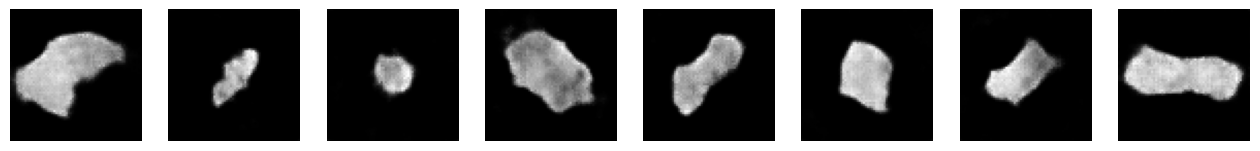

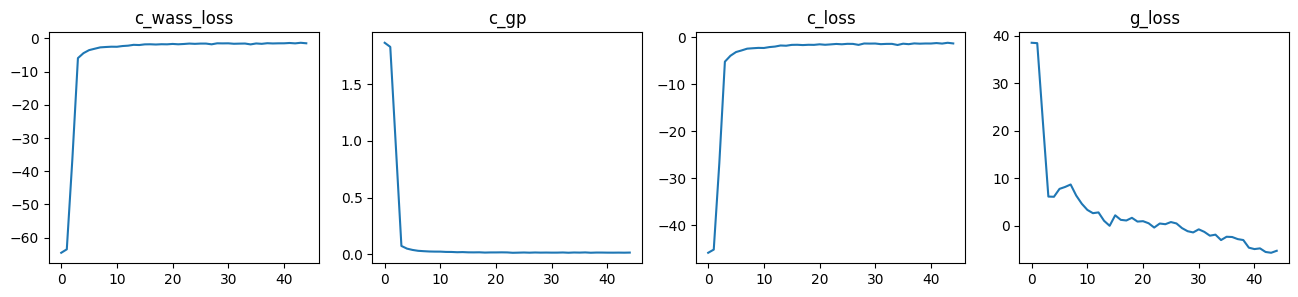

--- Checkpoint saved at epoch 44 to /content/drive/MyDrive/lego_wgan_gp_ckpt.pth ---


Training WGAN-GP:   0%|          | 0/72 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
lego_dataloader = get_dataloader()
history = defaultdict(list)

# for model checkpoint
CHECKPOINT_PATH = '/content/drive/MyDrive/lego_wgan_gp_ckpt.pth'
start_epoch, history = load_checkpoint(CHECKPOINT_PATH, wgan_gp.generator, wgan_gp.critic, g_optim, c_optim)

# for logger
writer = SummaryWriter('/content/drive/MyDrive/runs/lego_experiment_2')


for i in range(start_epoch, EPOCHS):
    prev_time = time.time()
    generated_imgs = train(wgan_gp, lego_dataloader, c_optim, g_optim, train_metrics)
    curr_time = time.time()



    for key, value in train_metrics.items():
        history[key].append(value.compute().item())

    display.clear_output(wait=True)

    print('Epoch: {}\tepoch time {:.2f} min'.format(i+1, (curr_time - prev_time) / 60))
    metrics = [f'{key}: {value.compute().item():.4f} | ' for key, value in train_metrics.items()]
    print('\t', ''.join(metrics))

    generated_imgs = generated_imgs.detach().cpu()
    display_imgs(generated_imgs)  # denormalize to [0, 1] for display
    show_records(history)
    writer.add_scalar('Wasserstein Loss/Critic', train_metrics['c_wass_loss'].compute(), i)
    writer.add_scalar('Gradient Penalty/Critic', train_metrics['c_gp'].compute(), i)
    writer.add_scalar('Loss/Generator', train_metrics['g_loss'].compute(), i)
    writer.add_scalar('Loss/Critic', train_metrics['c_loss'].compute(), i)

    if (i + 1) % 5 == 0:
        save_checkpoint(i, wgan_gp.generator, wgan_gp.critic, g_optim, c_optim, history, CHECKPOINT_PATH)
        # Use make_grid to see a batch of LEGOs at once
        grid = torchvision.utils.make_grid(generated_imgs[:16], normalize=True)
        writer.add_image('Generated_Bricks', grid, i)

writer.close()



In [ ]:
# sample lantent vector from normal distribution
grid_width, grid_height = (10, 3)
z_samples = torch.randn(size=(grid_width * grid_height, Z_DIM), device=DEVICE)
generated_imgs = dcgan.generate(z_samples)

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(generated_imgs[i][0].detach().cpu(), cmap="gray")

In [ ]:
total_imgs = None
for i, sample_batch in enumerate(lego_dataloader):
    if i == 0:
        total_imgs = sample_batch
    else:
        total_imgs = torch.cat([total_imgs, sample_batch], dim=0)
print(total_imgs.shape)

In [ ]:
grid_width, grid_height = (5, 3)
z_samples = torch.randn(size=(grid_width * grid_height, Z_DIM), device=DEVICE)
dcgan.eval()
with torch.no_grad():
    generated_imgs = dcgan.generate(z_samples).detach().cpu()

# Draw a plot of decoded images
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Generated images')

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(generated_imgs[i][0], cmap="gray")